Import libraries.

In [1]:
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Unpickle function to unpickle the data.

In [2]:
def unpickle(file_location):
    with open(file_location, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Unpickle each data to dictionary format.

In [3]:
data1 = unpickle('data/data_batch_1')
data2 = unpickle('data/data_batch_2')
data3 = unpickle('data/data_batch_3')
data4 = unpickle('data/data_batch_4')
data5 = unpickle('data/data_batch_5')
test_data = unpickle('data/test_batch')
labels = unpickle('data/batches.meta')

The unpickled data are in dictionary format, but the dictionary keys are in bytes not string. This part changes the keys to strings.

In [4]:
for data in [data1, data2, data3, data4, data5, test_data]:
    keys = [k for k in data]
    for key in keys:
        data[key.decode('utf-8')] = data[key]
        del data[key]

Functions to collect the examples and labels from the dataset in either RGB (coloured) or grayscale format will the written next. The `get_coloured_data()` function will output 32 by 32 pixel images with three channels (RGB) alongside their labels.

In [5]:
def get_coloured_data(data):
    data_red = data['data'][:, 0:1024] / 255
    data_green = data['data'][:, 1024:2048] / 255
    data_blue = data['data'][:, 2048:3072]  / 255

    data_label = data['labels']

    dstacked = np.dstack((data_red, data_green, data_blue))
    dstacked = dstacked.reshape((10000, 32, 32, 3))
    return dstacked, data_label

The `get_coloured_data()` function will then be used to get the images and their labels.

In [6]:
data1_3d, label1 = get_coloured_data(data1)
data2_3d, label2 = get_coloured_data(data2)
data3_3d, label3 = get_coloured_data(data3)
data4_3d, label4 = get_coloured_data(data4)
data5_3d, label5 = get_coloured_data(data5)
test, test_label = get_coloured_data(test_data)

Train, validation and test data will then be sought together.

In [7]:
X_train = np.vstack((data1_3d, data2_3d, data3_3d, data4_3d))
y_train = np.array(label1 + label2 + label3 + label4)

X_validation = data5_3d
y_validation = np.array(label5)

X_test = test
y_test = np.array(test_label)

Let's check the shape of our resulting dataset.

In [8]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (10000,)
(10000, 32, 32, 3) (10000,)


One hot encoding will be used to turn the labels into vectors with 10 dimensions.

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_validation = tf.keras.utils.to_categorical(y_validation, num_classes=10)

We will need a function to plot our loss and accuracy for both the train and validation datasets after our training is done. We will create a simple `plot()` function from `matplotlib`.

In [10]:
def plot(history):
    # Loss
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    # Accuracy
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()

    plt.show()

We will now create our Convolutional Neural Network.

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='sigmoid'))

Compile the model.

In [12]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

We will use early stopping to stop the training if the validation loss stops changing significantly, and also to avoid overfitting.

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Let's see the parameters of our model.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               8640300   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3010      
Total params: 8,644,206
Trainable params: 8,644,206
Non-trainable params: 0
_________________________________________________________________


Start the training.

In [15]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_validation, y_validation), batch_size=100, callbacks=[early_stopping])

Epoch 1/500
400/400 [==============================] - 116s 284ms/step - loss: 1.8763 - accuracy: 0.3652 - val_loss: 1.3224 - val_accuracy: 0.5380
Epoch 2/500
400/400 [==============================] - 112s 280ms/step - loss: 1.1991 - accuracy: 0.5826 - val_loss: 1.2065 - val_accuracy: 0.5773
Epoch 3/500
400/400 [==============================] - 112s 280ms/step - loss: 1.0224 - accuracy: 0.6459 - val_loss: 1.2278 - val_accuracy: 0.5784
Epoch 4/500
400/400 [==============================] - 115s 289ms/step - loss: 0.8722 - accuracy: 0.6979 - val_loss: 1.1773 - val_accuracy: 0.6041
Epoch 5/500
400/400 [==============================] - 113s 282ms/step - loss: 0.7215 - accuracy: 0.7543 - val_loss: 1.1738 - val_accuracy: 0.6081
Epoch 6/500
400/400 [==============================] - 114s 285ms/step - loss: 0.5778 - accuracy: 0.8088 - val_loss: 1.2106 - val_accuracy: 0.6145
Epoch 7/500
400/400 [==============================] - 113s 282ms/step - loss: 0.4574 - accuracy: 0.8541 - val_loss: 1

Let's see how our model performed over time.

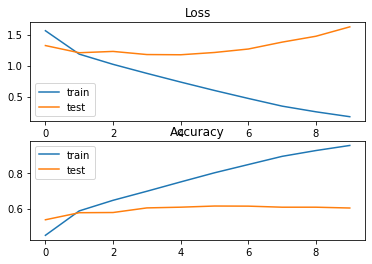

In [16]:
plot(history)

Check the accuracy of the model.

In [17]:
model.evaluate(X_train, y_train)

1250/1250 [==============================] - 46s 36ms/step - loss: 0.1255 - accuracy: 0.9693


[0.1255359947681427, 0.9693499803543091]

In [18]:
model.evaluate(X_validation, y_validation)

313/313 [==============================] - 12s 36ms/step - loss: 1.6241 - accuracy: 0.6035


[1.624137043952942, 0.6035000085830688]

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 11s 35ms/step - loss: 1.6484 - accuracy: 0.5937


[1.6483842134475708, 0.5936999917030334]

Save the model.

In [20]:
model.save("model/model")

INFO:tensorflow:Assets written to: model/model\assets
